# Import Libraries 📚

In [1]:
import os

from tensorflow import keras
import tensorflow as tf
import tensorflow_io as tfio

import numpy as np 
import pandas as pd
import soundfile as sf

import librosa
import IPython.display as ipd
import librosa.display as lid

import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.get_cmap('coolwarm')

2024-11-29 15:41:05.461314: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-29 15:41:05.667241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 15:41:05.761653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 15:41:05.762299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 15:41:05.915145: I tensorflow/core/platform/cpu_feature_gua

In [2]:
!pip install tensorflow_hub --no-deps



[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [17]:
!pip install tf_keras --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


## Library Version

In [3]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("TensorFlow-IO:", tfio.__version__)

print(tf.config.list_physical_devices('GPU'))

TensorFlow: 2.16.2
Keras: 3.4.1
TensorFlow-IO: 0.37.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-11-29 15:41:30.057042: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0f:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-29 15:41:30.113814: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0f:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-29 15:41:30.113849: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0f:00.0/numa_node
Your kernel may have been built without NUMA support.


# Configuration ⚙️

In [4]:
class CFG:
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 32
    
    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 16000 # VGGish takes 16kHz input
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    
    # Number of epochs, model name
    epochs = 10
    preset = 'efficientnetv2_b2_imagenet'
    
    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 24
    class_names = sorted(os.listdir('./birdclef-2024/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

# Reproducibility ♻️
Sets value for random seed to produce similar result in each run.

In [5]:
tf.keras.utils.set_random_seed(CFG.seed)

# Dataset Path 📁

In [6]:
BASE_PATH = './birdclef-2024'

In [7]:
df = pd.read_csv(fr'{BASE_PATH}/filtered_data_with_labels 1.csv').drop(columns = 'y')
df["filename"] = df["filename"] .str.split('/').apply(lambda x: '/'.join(x[-2:]))
df.index = df["filename"]
df.head()

,primary_label,type,latitude,longitude,rating,filename
filename,,,,,,
asbfly/XC134896.ogg,asbfly,['call'],39.2297,118.1987,5.0,asbfly/XC134896.ogg
asbfly/XC207738.ogg,asbfly,['call'],21.1697,70.6005,4.0,asbfly/XC207738.ogg
asbfly/XC209218.ogg,asbfly,['call'],15.5442,73.7733,4.0,asbfly/XC209218.ogg
asbfly/XC209219.ogg,asbfly,['call'],15.5442,73.7733,4.0,asbfly/XC209219.ogg
asbfly/XC267680.ogg,asbfly,"['call', 'male', 'song']",44.3602,132.7989,4.0,asbfly/XC267680.ogg


In [8]:
df = df.groupby('primary_label').sample(n=df.primary_label.value_counts().min(), random_state=42)

# Meta Data 📖

In [9]:
df.head()

,primary_label,type,latitude,longitude,rating,filename
filename,,,,,,
asbfly/XC305518.ogg,asbfly,['call'],20.2864,100.0577,3.0,asbfly/XC305518.ogg
asbfly/XC647397.ogg,asbfly,['call'],6.8922,80.1728,5.0,asbfly/XC647397.ogg
asbfly/XC291450.ogg,asbfly,['call'],10.1653,76.5476,3.0,asbfly/XC291450.ogg
asbfly/XC596043.ogg,asbfly,['call'],17.9361,102.6217,5.0,asbfly/XC596043.ogg
asbfly/XC134896.ogg,asbfly,['call'],39.2297,118.1987,5.0,asbfly/XC134896.ogg


In [10]:
df['filepath'] = BASE_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

# Display rwos
df.head(2)

,primary_label,type,latitude,longitude,rating,filename,filepath,target,xc_id
filename,,,,,,,,,
asbfly/XC305518.ogg,asbfly,['call'],20.2864,100.0577,3.0,asbfly/XC305518.ogg,./birdclef-2024/train_audio/asbfly/XC305518.ogg,0,XC305518
asbfly/XC647397.ogg,asbfly,['call'],6.8922,80.1728,5.0,asbfly/XC647397.ogg,./birdclef-2024/train_audio/asbfly/XC647397.ogg,0,XC647397


# EDA 🎨

## Utility

In [11]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CFG.sample_rate, 
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

## Sample 1

# Audio:


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


# Visualization:


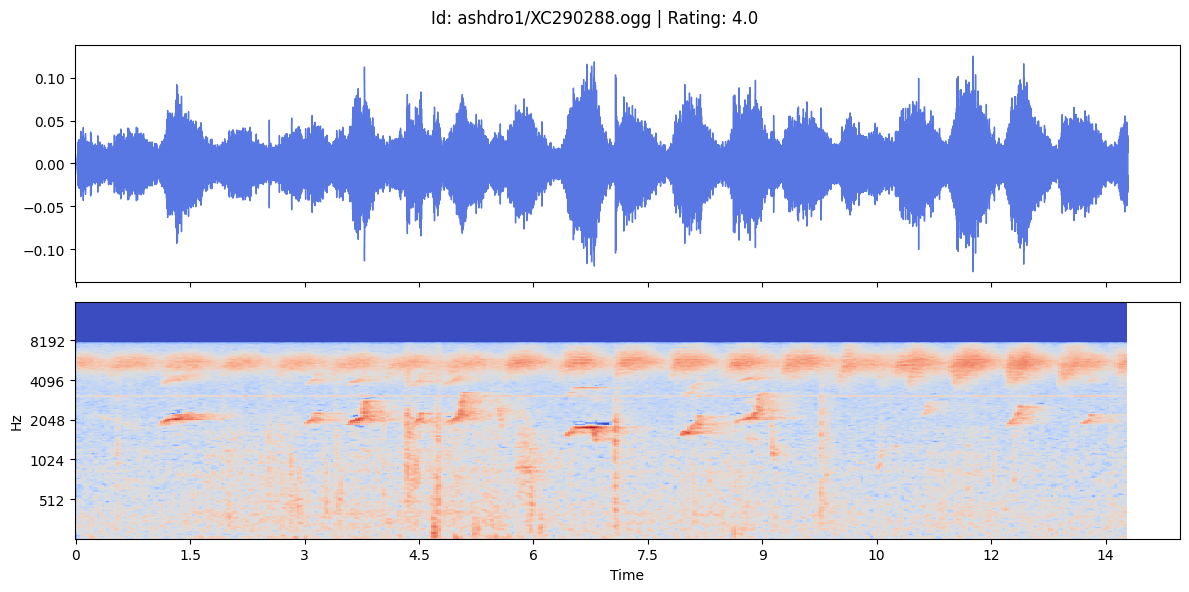

In [12]:
row = df.iloc[35]

# Display audio
display_audio(row)

## Sample 2

# Audio:


# Visualization:


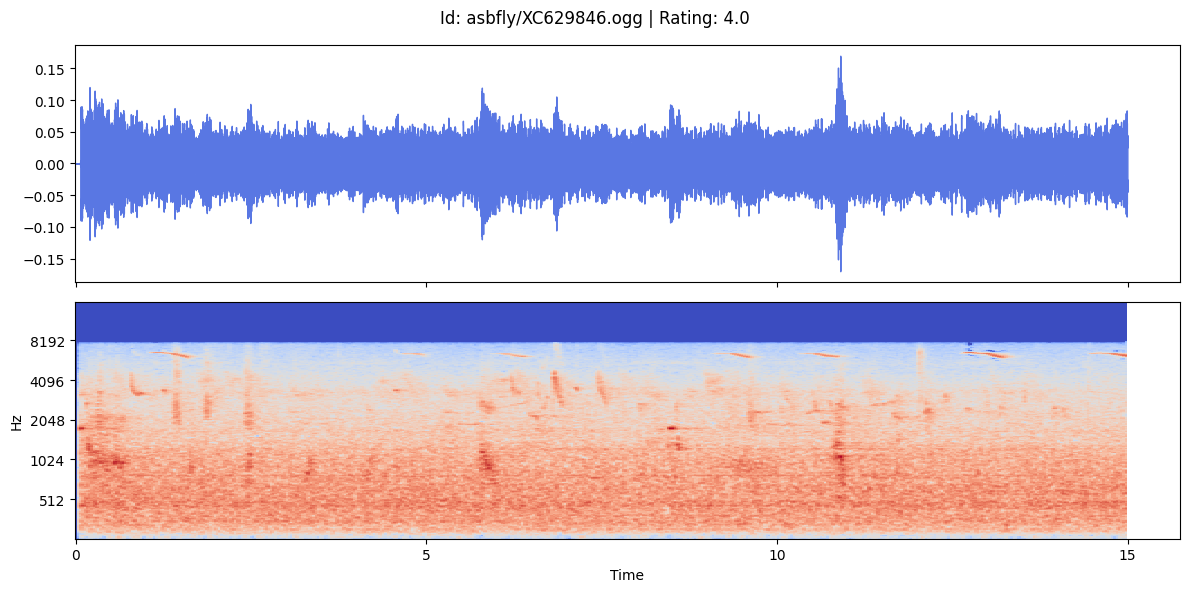

In [13]:
row = df.iloc[16]

# Display audio
display_audio(row)

## Sample 3

# Audio:


# Visualization:


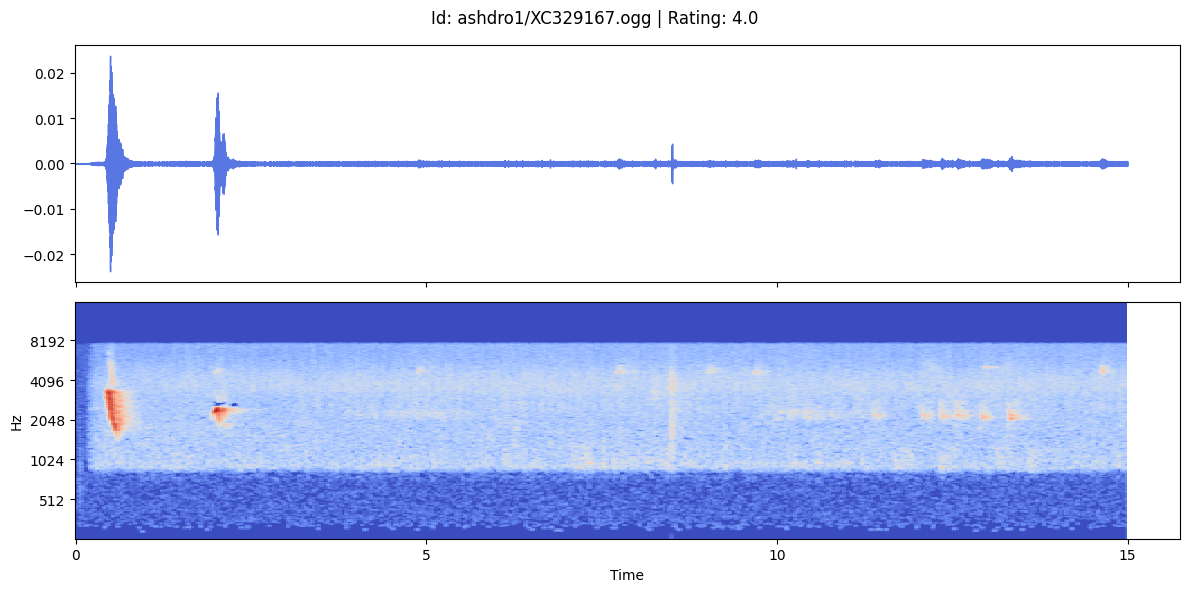

In [14]:
row = df.iloc[50]

# Display audio
display_audio(row)

# Data Split 🔪
Following code will split the data into folds using target stratification.
> **Note:** Some classess have too few samples thus not each fold contains all the classes. 

In [15]:
# Import required packages
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)

print(f"Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

Num Train: 1922 | Num Valid: 481


# Data Loader 🍚

## Decoders

The following code will decode the raw audio from `.ogg` file and also decode the spectrogram from the `audio` file. Additionally, we will apply Z-Score standardization and Min-Max normalization to ensure consistent inputs to the model.


In [18]:
import tensorflow_hub as hub
embedding_model = hub.load("https://tfhub.dev/google/vggish/1")

def build_decoder(with_labels=True, dim=1024):
    def get_audio(filepath):
        def _read_audio(path):
            path = path.decode('utf-8')  # Convert bytes to string
            audio, _ = librosa.load(path, sr=None, mono=True, dtype=np.float32)
            return audio

        # Use tf.numpy_function to wrap the Python function
        audio = tf.numpy_function(_read_audio, [filepath], tf.float32)
        audio.set_shape([None])  # Set the shape if known
        return audio

    def crop_or_pad(audio, target_len, pad_mode="constant"):
        audio_len = tf.shape(audio)[0]
        diff_len = abs(
            target_len - audio_len
        )  # find difference between target and audio length
        if audio_len < target_len:  # do padding if audio length is shorter
            pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad2 = diff_len - pad1
            audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
        elif audio_len > target_len:  # do cropping if audio length is larger
            idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            audio = audio[idx : (idx + target_len)]
        return tf.reshape(audio, [target_len])

    def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, CFG.num_classes), tf.float32)
        target = tf.reshape(target, [CFG.num_classes])
        return target

    def decode(path):
        # Load audio file
        audio = get_audio(path)
        # Crop or pad audio to keep a fixed length
        audio = crop_or_pad(audio, dim)
        
        # Use audio embedding model to get embeddings
        embeddings = embedding_model(audio)
        
        # Resize embeddings if necessary, depending on the model's output shape
        embeddings = tf.reshape(embeddings, [-1])  # Flatten embeddings to 1D
        
        return embeddings

    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label

    return decode_with_labels if with_labels else decode

2024-11-29 15:42:49.028218: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0f:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-29 15:42:49.028289: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0f:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-29 15:42:49.028314: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0f:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-29 15:42:49.248966: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0f:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-29 15:42:49.249006: I external/local_xla/xla/stream_executor

## Augmenters
Following code will apply augmentations to spectrogram data. In this notebook, we will use MixUp, CutOut (TimeMasking and FreqMasking) from KerasCV.

> Note that, these augmentations will be applied to batch of spectrograms rather than single spectrograms.

## Data Pipeline
Following code builds the complete pipeline of the data flow. It uses `tf.data.Dataset` for data processing. Here are some cool features of `tf.data`,
* We can build complex input pipelines from simple, reusable pieces using`tf.data` API . For example, the pipeline for an audio model might aggregate data from files in a distributed file system, apply random transformation/augmentation to each audio/spectrogram, and merge randomly selected data into a batch for training.
* Moreover `tf.data` API provides a `tf.data.Dataset` feature that represents a sequence of components where each component comprises one or more pieces. For instance, in an audio pipeline, a component might be a single training example, with a pair of tensor pieces representing the audio and its label.

Check out this [doc](https://www.tensorflow.org/guide/data) if you want to learn more about `tf.data`.

In [19]:
def build_dataset(paths, labels=None, batch_size=32, 
                  decode_fn=None, cache=True, shuffle=2048):
    # Use a default decode function if none is provided
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None, dim=CFG.audio_len)

    # Enable data parallelism and set up data loading pipeline
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths,) if labels is None else (paths, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    
    # Cache dataset for faster access if enabled
    if cache:
        ds = ds.cache()

    # Shuffle dataset if needed
    if shuffle:
        opt = tf.data.Options()
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    # Batch and prefetch dataset
    ds = ds.batch(batch_size, drop_remainder=True)
    ## try this if you wanna enable caching
    # ds = ds.repeat()
    ds = ds.prefetch(AUTO)
    
    return ds

## Build Train and Valid Dataloaders

In [20]:
# Train
train_paths = train_df.filepath.values
train_labels = train_df.target.values
train_ds = build_dataset(train_paths, train_labels, batch_size=CFG.batch_size, cache = False,
                         shuffle=True)

# Valid
valid_paths = valid_df.filepath.values
valid_labels = valid_df.target.values
valid_ds = build_dataset(valid_paths, valid_labels, batch_size=CFG.batch_size, cache = False,
                         shuffle=False)

In [21]:
# Take a single batch from the dataset to inspect the shape
for batch in train_ds.take(1):  # `ds` is the dataset created by `build_dataset`
    embeddings, labels = batch
    print("Embedding shape:", embeddings.shape)  # This will show the shape of the batch of embeddings
    print("Label shape:", labels.shape)


Embedding shape: (32, 1920)
Label shape: (32, 182)


2024-11-29 15:43:07.445649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# 🤖 Modeling

Building a model for an audio recognition task with spectrograms as input is quite straightforward, as it is very similar to image classification. This is because the shape of spectrogram data is very similar to image data. In this notebook, to perform the audio recognition task, we will utilize the `EfficientNetV2` ImageNet-pretrained model as the backbone. Even though this backbone is pretrained with ImageNet data instead of spectrogram data, we can leverage transfer learning to adapt it to our spectrogram-based task.

> Note that we can train our model on any duration audio file (here we are using `10 seconds`), but we will always infer on `5-second` audio files (as per competition rules). To facilitate this, we have set the model input shape to `(None, None, 3)`, which will allow us to have variable-length input during training and inference.


In case you are wondering, **Why not train and infer on both `5-second`?** In the train data, we have long audio files, but we are not sure which part of the audio contains the labeled bird's song. In other words, this is weakly labeled. To ensure the provided label is accurately suited to the audio, we are using a larger audio size than `5 seconds`. You are welcome to try out different audio lengths for training.


In [38]:
from tensorflow.keras import layers, models, optimizers

# Load the pre-trained VGGish model from TensorFlow Hub
vggish_layer = hub.KerasLayer("https://tfhub.dev/google/vggish/1", trainable=True, name="vggish")

# Define the input layer for raw audio embeddings
inp = layers.Input(shape=(CFG.audio_len,), name="audio_input")

# Pass the input through the VGGish model
x = vggish_layer(inp)

# Add dense layers for classification
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Output layer for classification
out = layers.Dense(CFG.num_classes, activation="softmax", name="classifier")(x)

# Build the model
model = models.Model(inputs=inp, outputs=out)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
    metrics=[
        keras.metrics.AUC(name="auc"),
        keras.metrics.CategoricalAccuracy(name="accuracy")
    ]
)

# Display the model summary
model.summary()

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


TypeError: Exception encountered when calling layer 'vggish' (type KerasLayer).

Binding inputs to tf.function failed due to `A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
`. Received args: (<KerasTensor shape=(None, 240000), dtype=float32, sparse=None, name=audio_input>,) and kwargs: {} for signature: (waveform: TensorSpec(shape=(None,), dtype=tf.float32, name=None)).

Call arguments received by layer 'vggish' (type KerasLayer):
  • inputs=<KerasTensor shape=(None, 240000), dtype=float32, sparse=None, name=audio_input>
  • training=None

# LR Schedule ⚓
* Learning Rate scheduler for transfer learning. 
* The learning rate starts from `lr_start`, then decreases to a`lr_min` using different methods namely,
    * **step**: Reduce lr step wise like stair.
    * **cos**: Follow Cosine graph to reduce lr.
    * **exp**: Reduce lr exponentially.

In [33]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

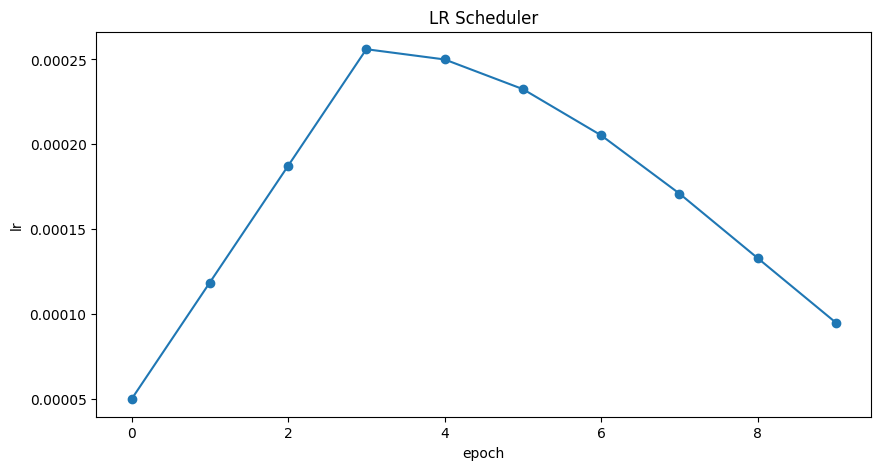

In [34]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

# Model Checkpoint 💾

In [35]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.weights.h5",
                                         monitor='val_auc',
                                         save_best_only=True,
                                         save_weights_only=True,
                                         mode='max')

# Training 🚄

In [36]:
from sklearn.metrics import f1_score
class F1Metrics(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(F1Metrics, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_true = []
        val_pred = []
        for batch in self.validation_data:
            x_val, y_val = batch
            y_pred = np.argmax(self.model.predict(x_val, verbose=0), axis=-1)
            y_true = np.argmax(y_val.numpy(), axis=-1) if len(y_val.shape) > 1 else y_val.numpy()
            
            val_true.extend(y_true)
            val_pred.extend(y_pred)

        macro_f1 = f1_score(val_true, val_pred, average='macro')
        weighted_f1 = f1_score(val_true, val_pred, average='weighted')

        print(f"\nEpoch {epoch + 1} - Macro F1: {macro_f1:.4f}, Weighted F1: {weighted_f1:.4f}")
        logs['macro_f1'] = macro_f1
        logs['weighted_f1'] = weighted_f1

In [37]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb, F1Metrics(valid_ds)],  # Add learning rate, checkpoint, and F1 callbacks
    verbose=1
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0092 - auc: 0.5065 - loss: 5.9540
Epoch 1 - Macro F1: 0.0011, Weighted F1: 0.0027
60/60 ━━━━━━━━━━━━━━━━━━━━ 582s 10s/step - accuracy: 0.0092 - auc: 0.5066 - loss: 5.9537 - val_accuracy: 0.0042 - val_auc: 0.5076 - val_loss: 5.2409 - learning_rate: 5.0000e-05 - macro_f1: 0.0011 - weighted_f1: 0.0027
Epoch 2/10


2024-11-29 15:59:19.708756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


37/60 ━━━━━━━━━━━━━━━━━━━━ 2:16 6s/step - accuracy: 0.0092 - auc: 0.5318 - loss: 5.7885

KeyboardInterrupt: 

## Result Summary

In [ ]:
# Find the epoch with the best Macro F1 score
best_epoch_macro_f1 = np.argmax(history.history["macro_f1"])
best_macro_f1_score = history.history["macro_f1"][best_epoch_macro_f1]

# Find the epoch with the best Weighted F1 score
best_epoch_weighted_f1 = np.argmax(history.history["weighted_f1"])
best_weighted_f1_score = history.history["weighted_f1"][best_epoch_weighted_f1]

# Print the best F1 scores
print('>>> Best Macro F1: ', best_macro_f1_score)
print('>>> Best Macro F1 Epoch: ', best_epoch_macro_f1 + 1)

print('>>> Best Weighted F1: ', best_weighted_f1_score)
print('>>> Best Weighted F1 Epoch: ', best_epoch_weighted_f1 + 1)


>>> Best AUC:  0.8787025213241577
>>> Best Epoch:  10


# Reference ✍️
* [BirdCLEF23: Pretraining is All you Need [Train]](https://www.kaggle.com/code/awsaf49/birdclef23-pretraining-is-all-you-need-train) by @awsaf49
* [RANZCR: EfficientNet TPU Training](https://www.kaggle.com/code/xhlulu/ranzcr-efficientnet-tpu-training) by @xhlulu
* [Triple Stratified KFold with TFRecords](https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords) by @cdeotte